In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [84]:
class State:
    def __init__(self, name):
        self.name = name
        self.ncities = 0
        self.city_data = {
            'pm25': None,
            'pm10': None,
            'o3': None,
            'no2': None,
            'so2': None,
            'co': None
        }
        # final df
        self.aqi_df = pd.DataFrame()
        
    def add_data(self, csv_path):
        self.ncities += 1
        import pandas as pd
        temp_df = pd.read_csv(city_data, parse_dates = ['date'], skipinitialspace = True)

        temp_df['date'] = pd.to_datetime(temp_df["date"])
        
        cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
        for col in cols:
            if col in temp_df.columns:
                temp_df[col] = pd.to_numeric(temp_df[col])
                new_name = col + '_' + str(self.ncities)
                temp_df.rename(columns={col: new_name}, inplace=True)
                if self.ncities == 1: self.city_data[col] = temp_df[['date', new_name]]
                else: self.city_data[col] = pd.merge(self.city_data[col], temp_df[['date', new_name]], on = "date", how = "inner")

#                 if col == 'pm25': print(csv_path, self.city_data[col].shape)
                    
    def get_state_aqi(self, kernel="random", sample_size=4, start_date='2020-01-01', end_date='2021-03-01'):
        for df_key in self.city_data.keys():
            self.city_data[df_key]['mean'] = self.city_data[df_key].drop('date', axis=1).apply(self.compute, kernel=kernel, sample_size=sample_size, axis=1)
        
        # assign state level aqi data
        self.aqi_df['date'] = self.city_data['pm25']['date']
        
        cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
        for col in cols:
            self.aqi_df[col] = self.city_data[col]['mean']
        
        self.aqi_df = self.aqi_df[(self.aqi_df['date'] > start_date) & (self.aqi_df['date'] < end_date)]
        
        
    @staticmethod
    def compute(row, kernel="random", sample_size=4):
        if kernel == "random":
            sample = row.sample(sample_size)
            return sample.mean()
    
    def get_city_data_today(self):
        today_pm25_df = self.city_data["pm25"].iloc[0]
        today_pm10_df = self.city_data["pm10"].iloc[0]
        
        today_data = np.empty((0, 2), 'float64')        
        for i in range(1, min(today_pm25_df.shape[0], today_pm10_df.shape[0]) - 1):
            today_data = np.append(today_data, np.array([[today_pm25_df[i], today_pm10_df[i]]]), axis=0)
        
        col_mean = np.nanmean(today_data, axis=0)
        inds = np.where(np.isnan(today_data))
        today_data[inds] = np.take(col_mean, inds[1])
        
        return today_data
    

In [85]:
import os
from glob import glob

DATA_PATH = "./data/"

haryana = State("Haryana")
maharashtra = State("Maharashtra")
uttar_pradesh = State("Uttar Pradesh")
delhi = State("Delhi")
karnataka = State("Karnataka")

states = [haryana, maharashtra, uttar_pradesh, delhi, karnataka]

for state in states:
    st_data_path = DATA_PATH + state.name
    for city_data in glob(os.path.join(st_data_path, '*.csv')):
        state.add_data(city_data)

In [86]:
for state in states:
    state.get_state_aqi(kernel="random", sample_size=6, start_date='2019-01-01', end_date='2021-03-01')
    state.aqi_df = state.aqi_df.set_index('date')

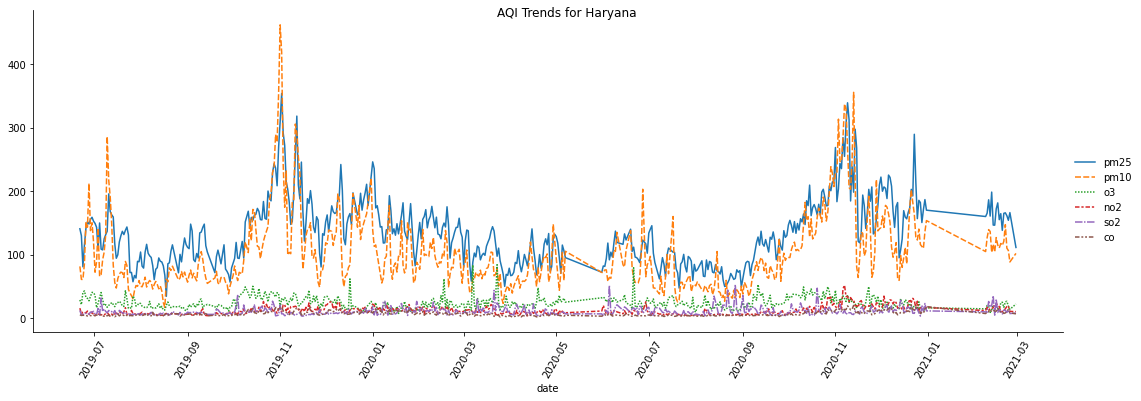

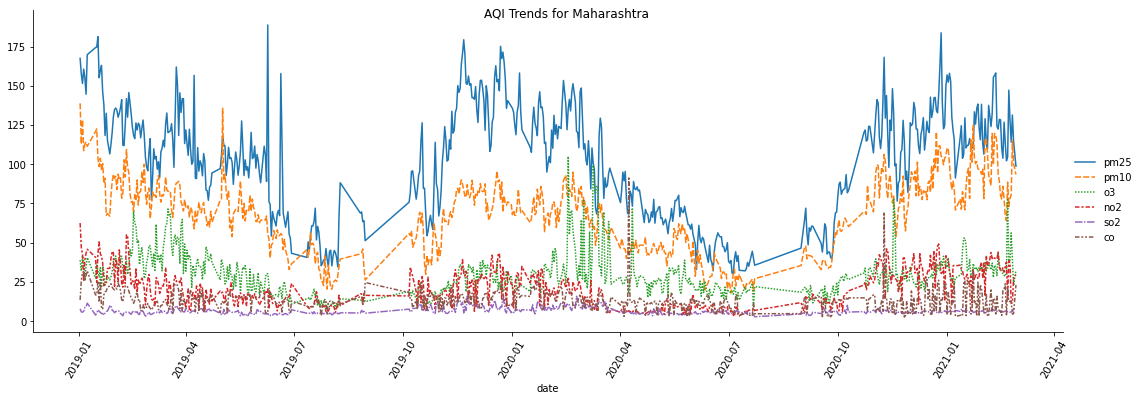

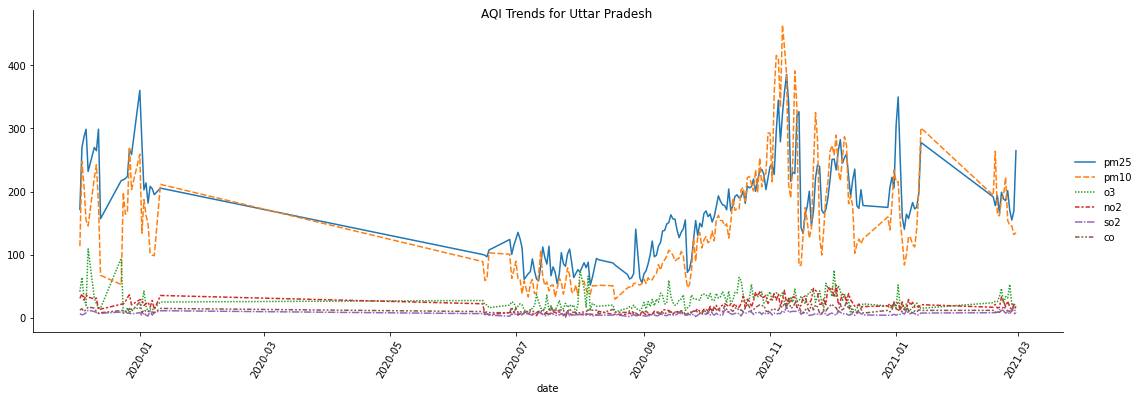

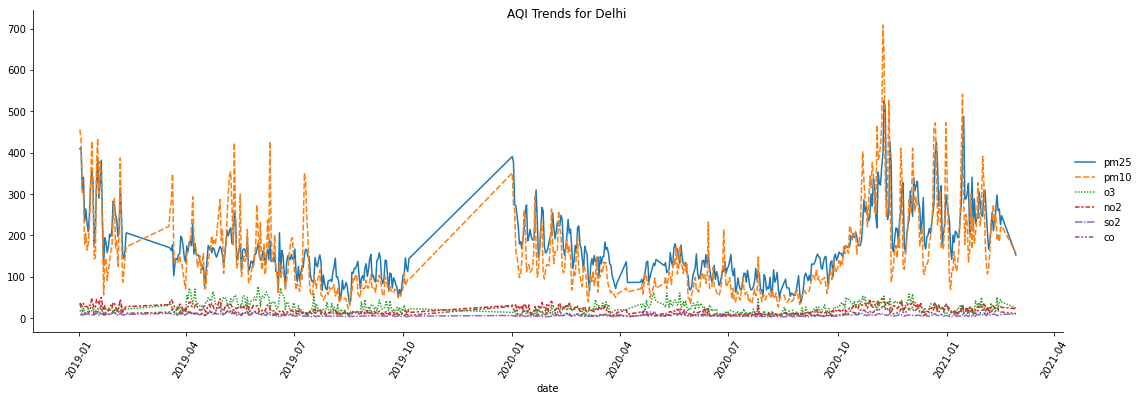

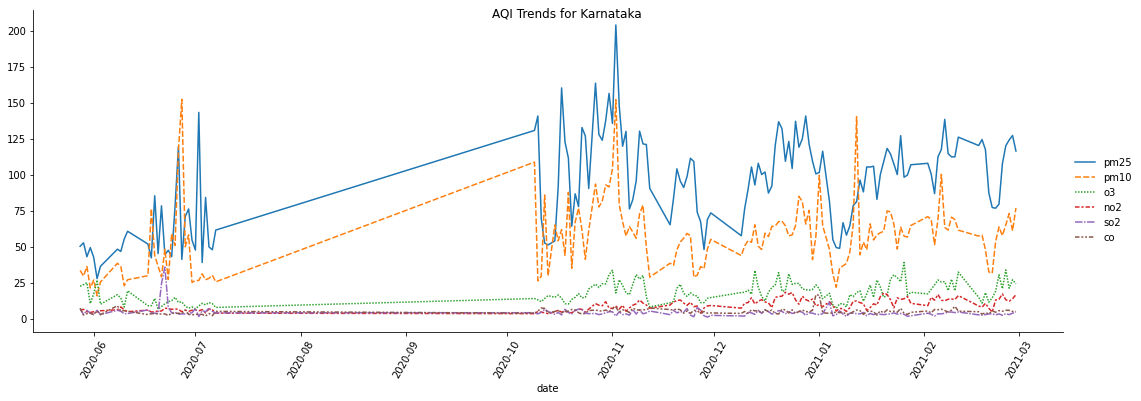

In [87]:
import matplotlib.pyplot as plt
for state in states:
    g = sns.relplot(data=state.aqi_df, kind='line', aspect=3)
    g.fig.suptitle(f"AQI Trends for {state.name}")
    g.set_xticklabels(rotation=60)
    plt.savefig(f'{state.name}_aqi_trend.png', bbox_inches='tight')
    

In [88]:
today_data = np.empty((0, 2), 'float64')
for state in states:
    td = state.get_city_data_today()
    today_data = np.append(today_data, state.get_city_data_today(), axis=0)

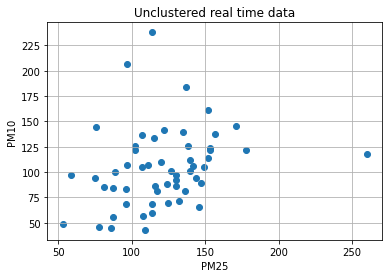

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
plt.scatter(today_data[:, 0], today_data[:, 1])
plt.xlabel('PM25')
plt.ylabel('PM10')
plt.title('Unclustered real time data')
plt.grid(True)
plt.savefig(f'realtime_uncl.png', bbox_inches='tight')
plt.show()

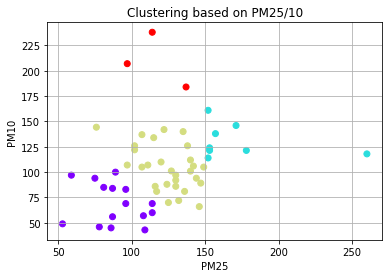

In [92]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(today_data)
plt.scatter(today_data[:, 0], today_data[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.xlabel('PM25')
plt.ylabel('PM10')
plt.title('Clustering based on PM25/10')
plt.grid(True)
plt.savefig(f'realtime_clk++.png', bbox_inches='tight')
plt.show()

In [50]:
mh_cdf = pd.read_csv('./data/covid/maharashtra.csv', parse_dates = ['Date'], skipinitialspace = True)
mh_cdf['Date'] = pd.to_datetime(mh_cdf["Date"])
mh_cdf = mh_cdf.drop(['Region'], axis=1)

In [51]:
mh_cdf.columns

Index(['Date', 'Confirmed Cases', 'Active Cases', 'Cured/Discharged', 'Death'], dtype='object')

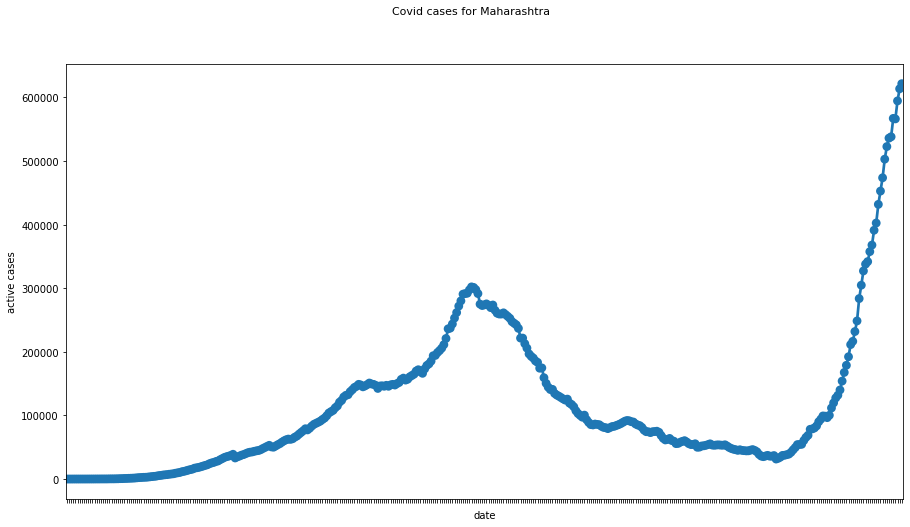

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = pd.DataFrame()
df['date'] = mh_cdf["Date"]
df['active cases'] = mh_cdf["Active Cases"]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Covid cases for Maharashtra', fontsize=11)
g = sns.pointplot(data=df, x='date', y='active cases')
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig(f'mh_cov.png', bbox_inches='tight')

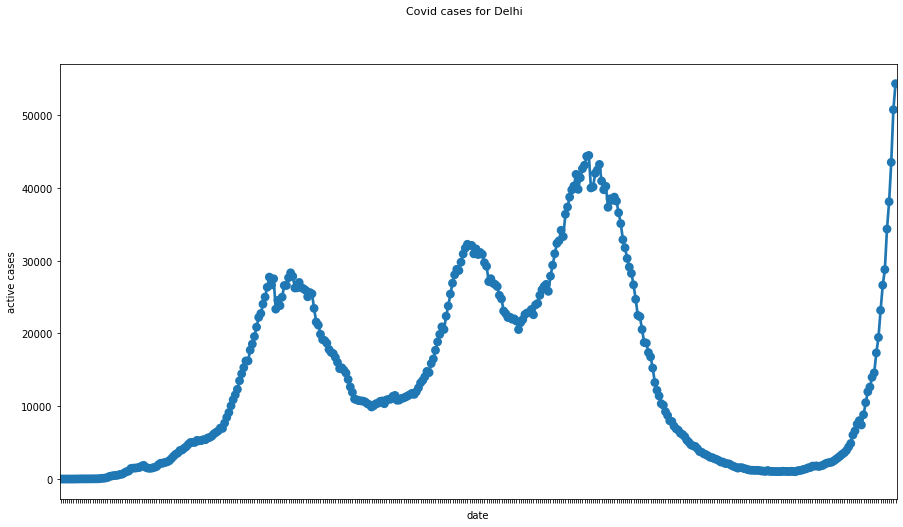

In [68]:
dl_cdf = pd.read_csv('./data/covid/delhi.csv', parse_dates = ['Date'], skipinitialspace = True)
dl_cdf['Date'] = pd.to_datetime(dl_cdf["Date"])
dl_cdf = dl_cdf.drop(['Region'], axis=1)
df = pd.DataFrame()
df['date'] = dl_cdf["Date"]
df['active cases'] = dl_cdf["Active Cases"]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Covid cases for Delhi', fontsize=11)
g = sns.pointplot(data=df, x='date', y='active cases')
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig(f'dl_cov.png', bbox_inches='tight')

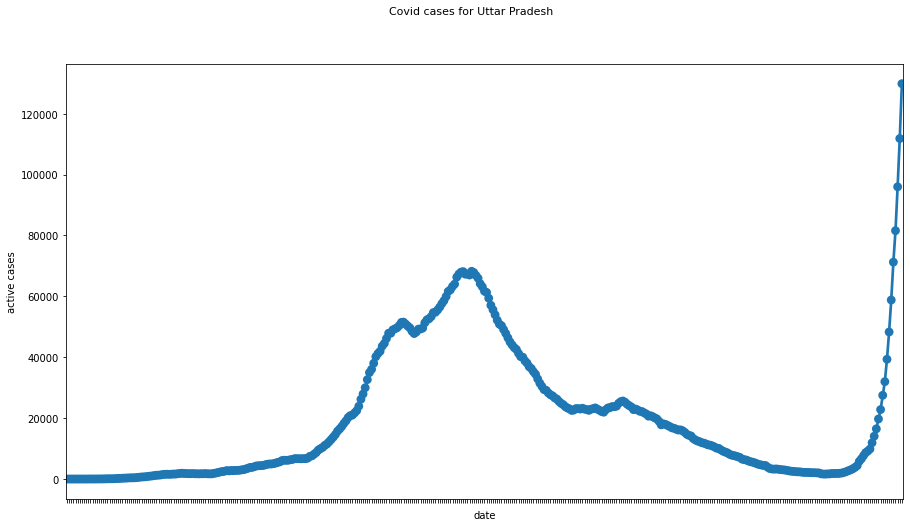

In [71]:
up_cdf = pd.read_csv('./data/covid/up.csv', parse_dates = ['Date'], skipinitialspace = True)
up_cdf['Date'] = pd.to_datetime(up_cdf["Date"])
up_cdf = up_cdf.drop(['Region'], axis=1)
df = pd.DataFrame()
df['date'] = up_cdf["Date"]
df['active cases'] = up_cdf["Active Cases"]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Covid cases for Uttar Pradesh', fontsize=11)
g = sns.pointplot(data=df, x='date', y='active cases')
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig(f'up_cov.png', bbox_inches='tight')

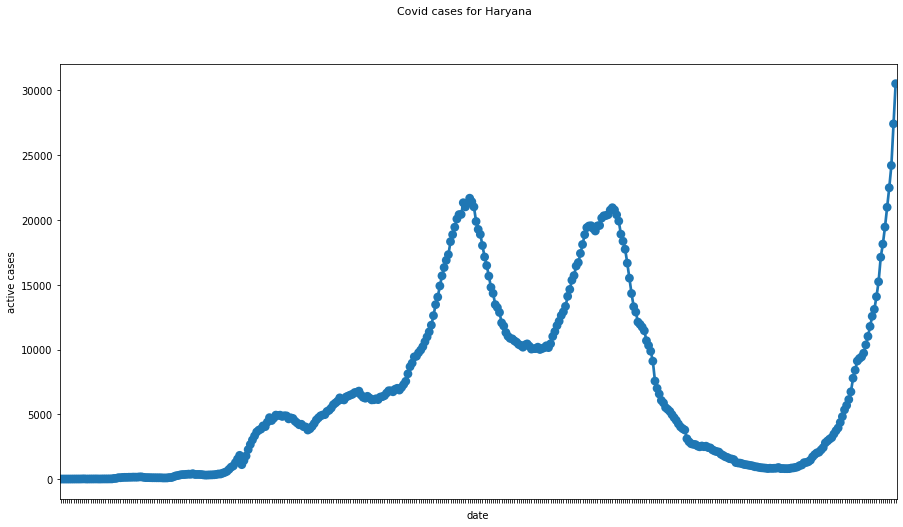

In [73]:
hr_cdf = pd.read_csv('./data/covid/haryana.csv', parse_dates = ['Date'], skipinitialspace = True)
hr_cdf['Date'] = pd.to_datetime(hr_cdf["Date"])
hr_cdf = hr_cdf.drop(['Region'], axis=1)
df = pd.DataFrame()
df['date'] = hr_cdf["Date"]
df['active cases'] = hr_cdf["Active Cases"]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Covid cases for Haryana', fontsize=11)
g = sns.pointplot(data=df, x='date', y='active cases')
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.savefig(f'hr_cov.png', bbox_inches='tight')